In [2]:
library(ggplot2)
library(tidyverse)
library(readxl)
library(MicrobeR)
library(vegan)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


ERROR: Error in library(MicrobeR): there is no package called ‘MicrobeR’


In [2]:
md<-read.csv('metadata.txt',
             row.names=1, sep='\t', check.names=FALSE) %>% rownames_to_column("SampleID") 
row.names(md)<-md$SampleID
head(md)

,SampleID,sample_type,project_ID,sequencing_region,diagnose,age,gender,BMI,tumor_site,T_stage,⋯,sequencing_region_merge,host_replicates,treatment_yn,replicate_2,HNSCC,_sample_id,_calour_original_abundance,observed_features,shannon_entropy,faith_pd
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>
SRR21105746,SRR21105746,Oral_rinse,PRJNA870048,V3-V4,OSCC,63,M,NA,tongue,,⋯,V3-V4,,,,,SRR21105746,48812,184,3.804584,16.04912
SRR6110936,SRR6110936,Saliva,PRJNA412445,V4-V5,OSCC,63,F,NA,,II,⋯,V4-V5,,,,,SRR6110936,113189,177,4.731407,18.01963
SRR5559431,SRR5559431,Saliva,PRJNA386665,V4,OSCC,48,M,NA,,,⋯,V3-V4,,,,,SRR5559431,145834,185,4.851843,19.47109
SRR5559472,SRR5559472,Saliva,PRJNA386665,V4,OSCC,45,M,NA,,,⋯,V3-V4,,,,,SRR5559472,94157,194,4.315743,19.95387
SRR15720152,SRR15720152,Oral_rinse,PRJNA744870,V3-V4,Healthy_control,NA,,NA,,,⋯,V3-V4,,,,,SRR15720152,105411,154,4.485692,15.65140
SRR5559561,SRR5559561,Saliva,PRJNA386665,V4,OSCC,49,M,NA,,,⋯,V3-V4,,,,,SRR5559561,94015,141,4.164621,15.49631


In [3]:
table(md$diagnose)


Healthy_control            OPMD            OSCC 
            393             172             494 

In [4]:
dim(md)

[1] 1059   37

In [5]:
alphas<-c('observed_features','shannon_entropy', 'faith_pd')

# healthy_control vs OSCC

In [6]:
count(md, project_ID, diagnose)

project_ID,diagnose,n
<chr>,<chr>,<int>
OEP000837,Healthy_control,12
OEP000837,OSCC,32
PRJEB37501,OPMD,28
PRJEB37501,OSCC,45
PRJEB39064,Healthy_control,25
PRJEB39064,OPMD,21
PRJEB39064,OSCC,27
PRJNA386665,Healthy_control,127
PRJNA386665,OPMD,123


In [7]:
projects=c('OEP000837','PRJEB39064','PRJNA386665','PRJNA421234','PRJNA700849','PRJNA744870',
           'PRJNA751046','PRJNA756784','PRJNA870048')

In [8]:
Alpha_stat<- function(p){


    As <-list()

    As$md <-subset(md,project_ID==p) %>% subset(diagnose=='Healthy_control'| diagnose=='OSCC')

    for (Alpha in alphas){
        min_alpha=min(As$md[which(As$md[Alpha]!=0),Alpha])
        As$md[which(As$md[Alpha]==0),Alpha]<- min_alpha 
    }


    As$alpha_div <- As$md %>%
    as_tibble() %>%  # 变成tibble ，dataframe的一种
    gather(key="Metric", value="Diversity",shannon_entropy,faith_pd, observed_features) %>% 
    select(SampleID,project_ID,diagnose, Metric, Diversity)
    

    As$alpha_div <- As$alpha_div %>%
    left_join(
        As$alpha_div %>%
        group_by(Metric, diagnose) %>%
        summarize(mean=mean(log2(Diversity))) %>%  
       spread(key=diagnose, value=mean) %>%
       rename(mean_log2HC=Healthy_control, mean_log2OSCC=OSCC) #*
    ) %>%

    mutate(log2FC=log2(Diversity)-mean_log2HC)



    As$AlphaDiversity_Stats <-
    As$alpha_div %>%
    group_by(Metric) %>% 
    mutate(diagnose=factor(diagnose, levels=c("OSCC", "Healthy_control"))) %>% 
    do(
      broom::tidy(t.test(log2FC~diagnose, data=., conf.int=TRUE, conf.level=0.95)) # 在每个study中对OSCC和healthy做t test
    ) %>%
    mutate(project_ID= p) %>%
    select(project_ID, Metric, log2FC=estimate, Pvalue=p.value, 
           mean_HC=estimate2, mean_OSCC=estimate1, CI_low=conf.low, CI_high=conf.high) #* estimate1 对应谁怎么看

    return(As)
}

In [9]:
PerStudy<-list()
  for(p in projects){
    message("--------------------->", p)
    PerStudy[[p]]<-Alpha_stat(p)
  }

--------------------->OEP000837

`summarise()` has grouped output by 'Metric'. You can override using the
`.groups` argument.
Joining with `by = join_by(Metric)`
--------------------->PRJEB39064

`summarise()` has grouped output by 'Metric'. You can override using the
`.groups` argument.
Joining with `by = join_by(Metric)`
--------------------->PRJNA386665

`summarise()` has grouped output by 'Metric'. You can override using the
`.groups` argument.
Joining with `by = join_by(Metric)`
--------------------->PRJNA421234

`summarise()` has grouped output by 'Metric'. You can override using the
`.groups` argument.
Joining with `by = join_by(Metric)`
--------------------->PRJNA700849

`summarise()` has grouped output by 'Metric'. You can override using the
`.groups` argument.
Joining with `by = join_by(Metric)`
--------------------->PRJNA744870

`summarise()` has grouped output by 'Metric'. You can override using the
`.groups` argument.
Joining with `by = join_by(Metric)`
-------------------

In [10]:
# PerStudy$OEP000837$AlphaDiversity_Stats

In [11]:
# head(PerStudy)

In [12]:
mod<-lapply(PerStudy, function(x) x$alpha_div) %>%
  do.call(bind_rows, .) %>%
  mutate(diagnose=factor(diagnose, levels=c("Healthy_control","OSCC"))) %>% 
  group_by(Metric)

In [13]:
head(mod) 

SampleID,project_ID,diagnose,Metric,Diversity,mean_log2HC,mean_log2OSCC,log2FC
<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
S028-TY,OEP000837,OSCC,shannon_entropy,4.340670,1.710656,2.218344,0.4072616
S030-TY,OEP000837,OSCC,shannon_entropy,4.385159,1.710656,2.218344,0.4219729
S037-TY,OEP000837,OSCC,shannon_entropy,5.250524,1.710656,2.218344,0.6818052
S026-TY,OEP000837,OSCC,shannon_entropy,3.792121,1.710656,2.218344,0.2123488
S032-TY,OEP000837,OSCC,shannon_entropy,5.507239,1.710656,2.218344,0.7506730
S007-TY,OEP000837,OSCC,shannon_entropy,5.020677,1.710656,2.218344,0.6172259


In [14]:
table(mod$Metric)


         faith_pd observed_features   shannon_entropy 
              788               788               788 

In [15]:
dim(subset(md, project_ID %in% projects) %>% subset(diagnose != "OPMD"))

[1] 788  37

In [16]:
AlphaCombined<-tibble(project_ID=character(0), Metric=character(0), 
                      log2FC=numeric(0), Pvalue=numeric(0), mean_HC=numeric(0), 
                      mean_OSCC=numeric(0), CI_low=numeric(0), CI_high=numeric(0))

for(i in unique(mod$Metric)){
  fit<-lmerTest:::lmer(log2FC~diagnose+(1|project_ID), data=subset(mod, Metric==i))
  cf<-confint(fit,level = 0.95)
  
  AlphaCombined<-bind_rows(AlphaCombined, tibble(
    project_ID="Combined", 
    Metric=i, 
    log2FC=summary(fit)$coefficients["diagnoseOSCC", "Estimate"], 
    Pvalue=anova(fit)$`Pr(>F)`,  
    mean_HC=NA, 
    mean_OSCC=NA, 
    CI_low=cf["diagnoseOSCC",1],  
    CI_high=cf["diagnoseOSCC",2] 
  ))
}

Computing profile confidence intervals ...

Computing profile confidence intervals ...

Computing profile confidence intervals ...



In [17]:
AlphaCombined

project_ID,Metric,log2FC,Pvalue,mean_HC,mean_OSCC,CI_low,CI_high
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Combined,shannon_entropy,0.03210375,0.03171331,NA,NA,0.002939196,0.06146973
Combined,faith_pd,0.02062262,0.18009935,NA,NA,-0.009313114,0.05111640
Combined,observed_features,-0.03262318,0.16479658,NA,NA,-0.078305798,0.01395776


In [18]:
set_front <- function (size=9){
    theme(axis.text.x=element_text(angle=45, hjust=1,size=size),
          axis.text.y=element_text(size=size),
      axis.text = element_text(size = size,colour = 'black'),
      legend.title = element_text(size = size),
     legend.text = element_text(size = size),
     strip.text = element_text(size = size))
    #return(p)
}    

In [19]:
NSamples<-
  lapply(names(PerStudy), function(x) tibble(project_ID=x, Nsamples=length(unique(PerStudy[[x]]$alpha_div$SampleID)))) %>% 
  do.call(bind_rows, .) %>% 
  arrange(desc(Nsamples)) %>% 
  mutate(Study=paste0(project_ID, " (n=", Nsamples,")")) %>% 
  bind_rows(tibble(project_ID="Combined", Study="Combined")) %>%
  mutate(Study=factor(Study, levels=rev(Study)))

res<- lapply(PerStudy, function(x) x$AlphaDiversity_Stats) %>%
do.call(bind_rows, .) %>%
bind_rows(AlphaCombined) %>%
mutate(Significant=case_when(
Pvalue<0.05 & log2FC>0 ~ "* higher in OSCC",
Pvalue<0.05 & log2FC<0 ~ "* higher in healthy control",
TRUE~"ns"
)) %>%
ungroup() %>%
mutate(Metric=factor(Metric, levels=alphas))%>%
#mutate(BioProject=factor(BioProject, levels=c('PRJEB21104','PRJEB22107','PRJEB26931','Combined')))%>%           
left_join(NSamples) 

Joining with `by = join_by(project_ID)`


In [20]:
# head(res)

In [21]:
Hcolor="#E69F00"
Lcolor="#0072B2"

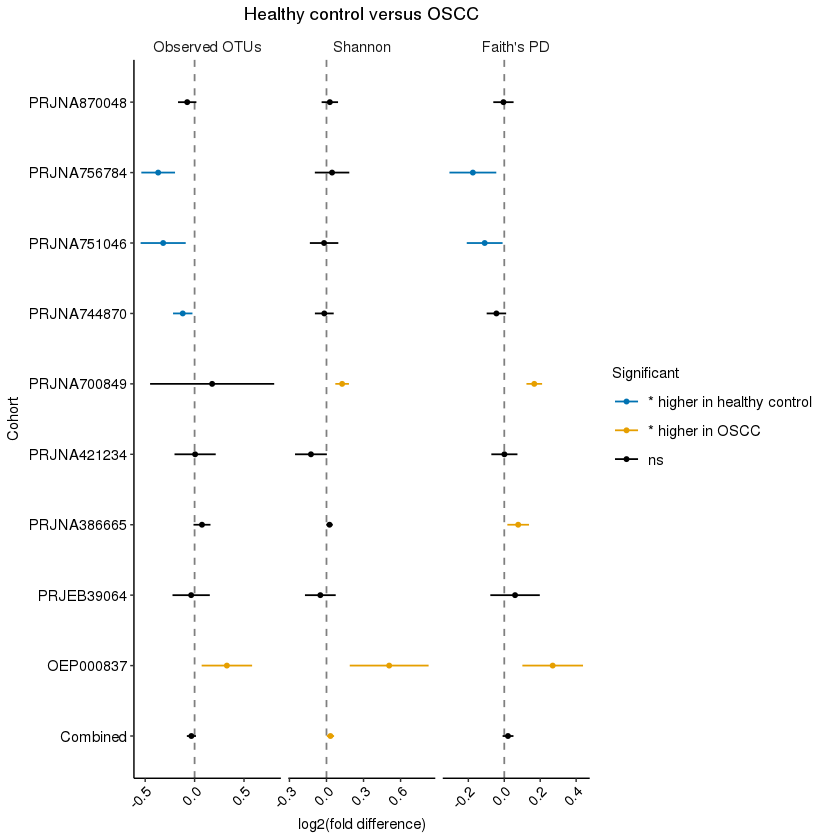

In [155]:
res <- res %>% mutate(Metric = recode(Metric,'shannon_entropy'='Shannon',
                     'faith_pd'="Faith's PD",'observed_features'='Observed OTUs'))

ggplot(res,aes(x=log2FC, y=project_ID, color=Significant)) +  
geom_vline(xintercept = 0, linetype="dashed", color="grey50") +
geom_errorbarh(aes(xmin=CI_low, xmax=CI_high), height=0 ) +
geom_point(size=1) +
facet_grid(~Metric, scales="free_x") +
theme_MicrobeR() +
scale_color_manual(values=c(Lcolor, Hcolor, "black"))  +
theme(panel.border = element_blank(), axis.line = element_line(),
      plot.title = element_text(hjust = 0.5)) + 
             set_front(9)+xlab('log2(fold difference)')+
labs(title="Healthy control versus OSCC",y='Cohort')